#Оценка качества изображений

**Постановка задачи**: Фотографии загружаемые поставщиками WB имеют разное качество: На одних может быть сложный фон, на каких-то фотографиях часть объекта не попала в кадр и.т.п. Для последующей работы с такими данными, например при использовании алгоритмов поиска по фото надо знать типs дефектов/овособенностей которые присутствуют на изображении.

<img src ="https://ml.gan4x4.ru/wb/quality/content/samples.png" width="800">


Всего 6 типов особенностей:  

* untidy,
* angle-composition,
* background,
* crop,
* text,
* multiple-objects

и один класс для изображений без дефектов
* good-image.

При этом изображение может содержать несколько видов дефектов.


Задача:

Требуется создать модель которая будет определять список дефектов для для изображения.

# Данные

По [ссылке](https://ml.gan4x4.ru/wb/quality/5000/student_5000.zip) доступен архив содержащий 5000 изображений и разметку.

Оригинальные изображения имели размер 900x1200 в датасете их разрешение уменьшено вдвое. Кроме изображений в архиве находиться csv файл c разметкой.
В первой колонке имя файла с изображением (без расширения), в остальных колонках названия классов к которым относиться изображение:

```
  18715,text,multiple-objects,,
  5259,text,background,,
  8932,background,,,
  ...

```

# Порядок выполнения задания

Задание рекомендуется выполнять по шагам:

1. Познакомьтесь с данными
2. Выберите метрику для оценки результата
3. Проведите анализ состояния вопроса, изучите существующие модели которые можно использовать для решения задачи
4. Проведите EDA, опишите особенности данных и проблемы которые они могут за собой повлечь
5. Подготовьте данные для обучения
6. Выберите baseline модель, оцените качество её работы на данном датасете.
7. Попробуйте улучшить значение метрики используя другую модель. Возможно обучив/дообучив ее.
8. Оцените быстродействие выбранной модели
9. Дайте оценку полученному результату.


**Важно!**

Блокнот должен содержать весь необходимый код для запуска финальной модели. Если для запуска требуется подгрузка весов, все ссылки длжны работать не только в вашем аккаунте но и в аккаунте преподавателя.

## Анализ данных (EDA)

In [6]:
!wget https://ml.gan4x4.ru/wb/quality/5000/student_5000.zip
!unzip student_5000.zip

--2024-06-24 10:27:53--  https://ml.gan4x4.ru/wb/quality/5000/student_5000.zip
Resolving ml.gan4x4.ru (ml.gan4x4.ru)... 212.24.105.216
Connecting to ml.gan4x4.ru (ml.gan4x4.ru)|212.24.105.216|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114875224 (110M) [application/zip]
Saving to: ‘student_5000.zip.2’

student_5000.zip.2  100%[===================>] 109.55M  11.2MB/s    in 10s     

2024-06-24 10:28:04 (10.7 MB/s) - ‘student_5000.zip.2’ saved [114875224/114875224]

Archive:  student_5000.zip
replace 5000/5000.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [301]:
# ------------------------------------- #
#               Libraries               #
# ------------------------------------- #

import os, re, gc
import sys,time,random
# from numba import jit , cuda
import numpy as np
import pandas as pd
import shutil
import pathlib
import pickle
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import PIL
import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader , Dataset
from torch.optim import AdamW
import torchvision
from torchvision import models
from torchvision import transforms as T

import timm

import pytorch_lightning as pl
from lightning import LightningModule,Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping


print("Done!")

Done!


In [94]:
# -------------------------------------- #
#     training dirs, model paths, etc    #
# -------------------------------------- #

input_dir = "./5000/"
train_dir = "./5000/images/"
train_csv_path = "./5000/5000.csv"

In [83]:
# ---------------------------------------------------- #
#    Configuration class contains training configs     #
#                  &  model configs                    #
# ---------------------------------------------------- #

class Config:
        BATCH_SIZE = 32
        KFOLD = 5
        FOLD = 0
        SEED = 21
        LEARNING_RATE = 8e-6
        TYPE  = "Multi-label Image Classification"
        DATA_SOURCE = "multi-label-image-classification-dataset"
        MODEL_NAME = 'resnetv2_50'
        CRITERION_ = "Binary Cross Entropy"
        OPTIMIZER_ = "AdamW"
        DATA_TYPE = 'image'
        DATA_FORMAT = '.jpg'
        IMG_SIZE = (384,384)
        EPOCHS = 10
        
        def __init__(self):
            print("configuration set!")
        
        def check_cuda(self):
            print("Scanning for CUDA")
            if torch.cuda.is_available():
                print("GPU is available , training will be accelerated! : )\n")
            else:
                print("NO GPUs found : / \n")
        
        def seed_everything(self):
            print("Seeding...")
            np.random.seed(self.SEED)
            random.seed(self.SEED)
            os.environ['PYTHONHASHSEED'] = str(self.SEED)
            torch.manual_seed(self.SEED)
            torch.cuda.manual_seed(self.SEED)
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False
            print("Seeded everything!")

CFG = Config()
CFG.seed_everything()

configuration set!
Seeding...
Seeded everything!


In [ ]:
# Познакомьтесь с данными

In [164]:
def data_sanity_check(df):
    """
        this will check each image file for corrupted or missing and 
        returns index of corrupted / missing files .Doing this will
        prevent us from running into any data errors during training phase .
    """
    idx = []
    start = time.time()
    for i in range(len(df)):
        try:#       checks for corrupeted or missing image files
            if len(cv2.imread(df.iloc[i,0])) == 3:
                _ = 1
        except:
            idx.append(df.iloc[i,0])
    end = time.time()
    print(end-start)
    _ = gc.collect()
    return idx



4.586364269256592


[]

In [166]:
index = train_dir + pd.read_csv(train_csv_path, header=None, usecols=[0], dtype=str) + Config.DATA_FORMAT
index = index[0]

targets = pd.read_csv(train_csv_path, header=None, usecols = [1,2,3,4], keep_default_na=False)
targets = targets.apply(' '.join , axis=1)
targets = targets.str.strip()

train_df = pd.DataFrame({'index': index, 'targets': targets})

dsc = data_sanity_check()
print(dsc)

train_df = train_df.loc[~train_df["index"].isin(dsc)]

4.448807239532471
[]


In [191]:
targets_list = train_df['targets'].apply(lambda x: x.split())

mlb = MultiLabelBinarizer().fit(targets_list)
one_hot_targets = pd.DataFrame(mlb.transform(targets_list), columns=mlb.classes_)
train_df[one_hot_targets.columns] =  one_hot_targets
train_df

,index,targets,angle-composition,background,crop,good-image,multiple-objects,text,untidy
0,./5000/images/18715.jpg,text multiple-objects,0,0,0,0,1,1,0
1,./5000/images/5259.jpg,text background,0,1,0,0,0,1,0
2,./5000/images/8932.jpg,background,0,1,0,0,0,0,0
3,./5000/images/6070.jpg,good-image,0,0,0,1,0,0,0
4,./5000/images/13889.jpg,good-image,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
4995,./5000/images/12027.jpg,text,0,0,0,0,0,1,0
4996,./5000/images/23246.jpg,good-image,0,0,0,1,0,0,0
4997,./5000/images/1534.jpg,good-image,0,0,0,1,0,0,0
4998,./5000/images/10381.jpg,background,0,1,0,0,0,0,0


<Axes: title={'center': 'Target Class Distribution'}>

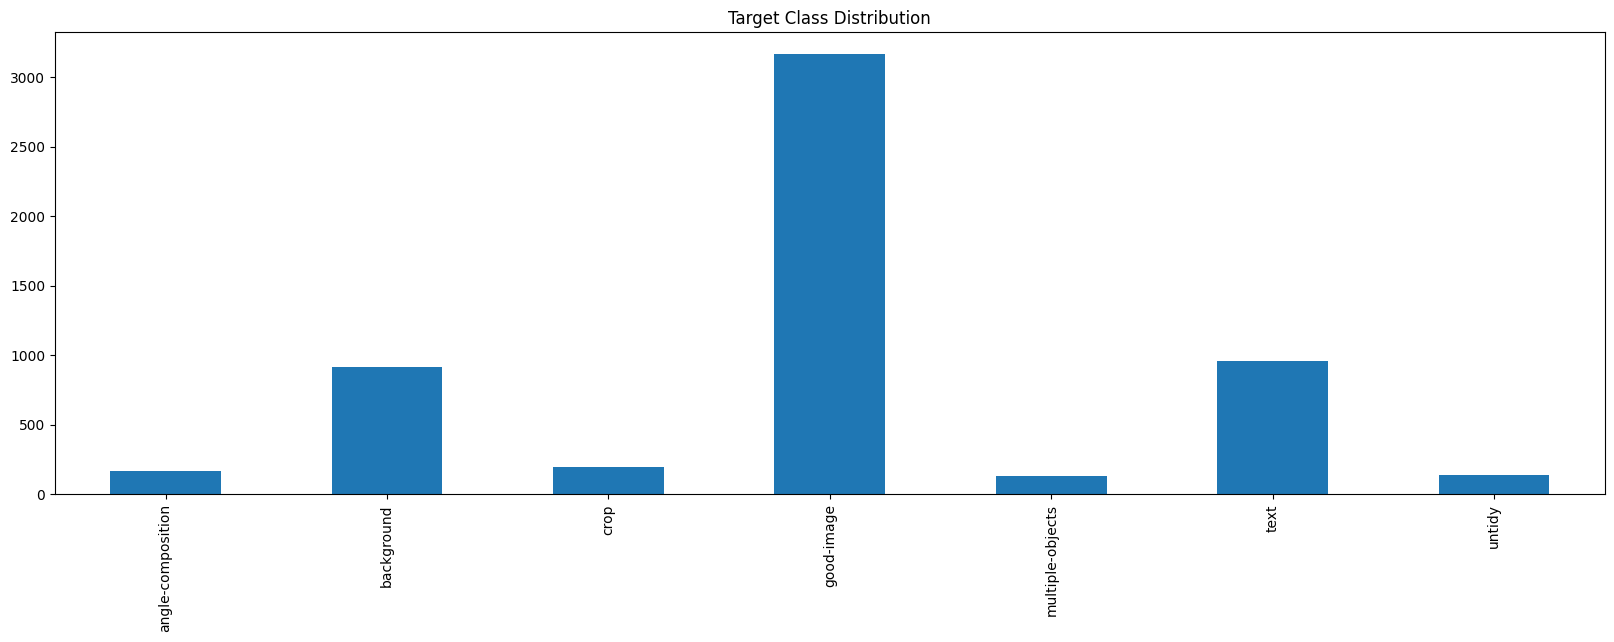

In [161]:
fig, ax = plt.subplots(figsize=(20, 6))
one_hot_targets.sum().plot.bar(title='Target Class Distribution')

<Axes: title={'center': 'Distribution of Number of Labels per Image'}>

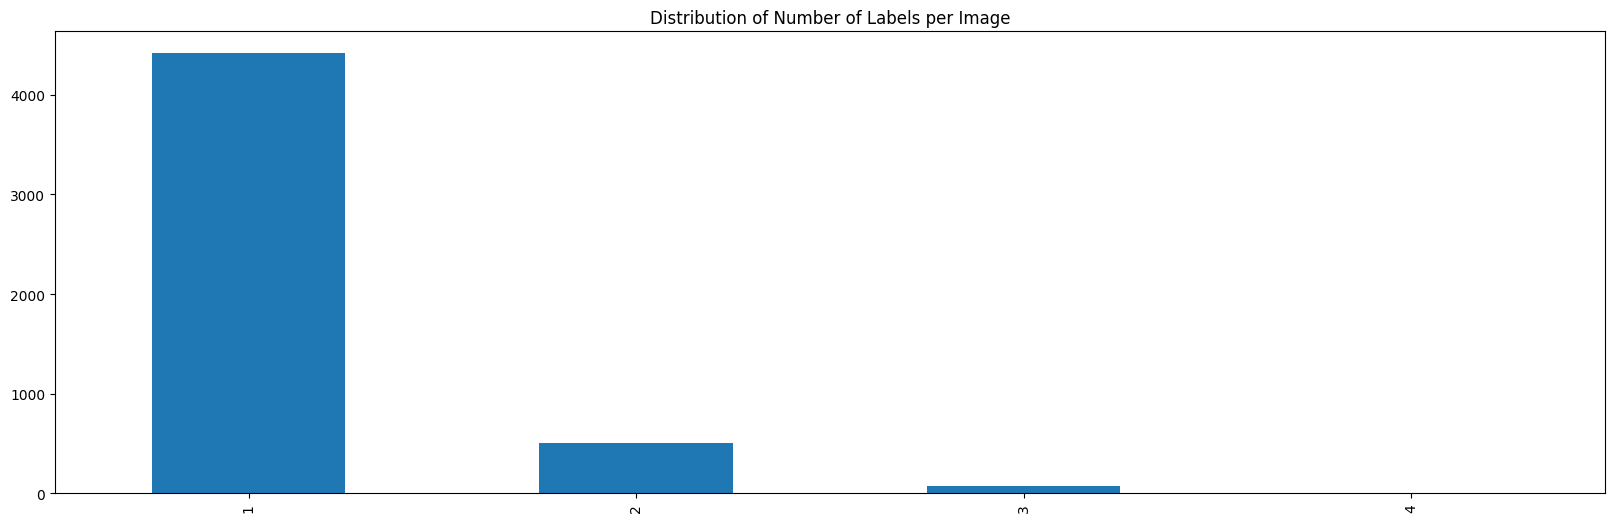

In [162]:
fig, ax = plt.subplots(figsize=(20, 6))
one_hot_targets.sum(axis=1).value_counts().plot.bar(title='Distribution of Number of Labels per Image')

In [183]:
def plot_img_grid(row, col, df):
    k = 1
    fig = plt.figure(figsize=(3*col, 4*row))
    for k in range(row*col):
        img = cv2.cvtColor(cv2.imread(df.iloc[k,0]),cv2.COLOR_BGR2RGB)
        ax = fig.add_subplot(row,col,k+1)
        ax.title.set_text(df.iloc[k,1])
        plt.imshow(img)
    plt.show()

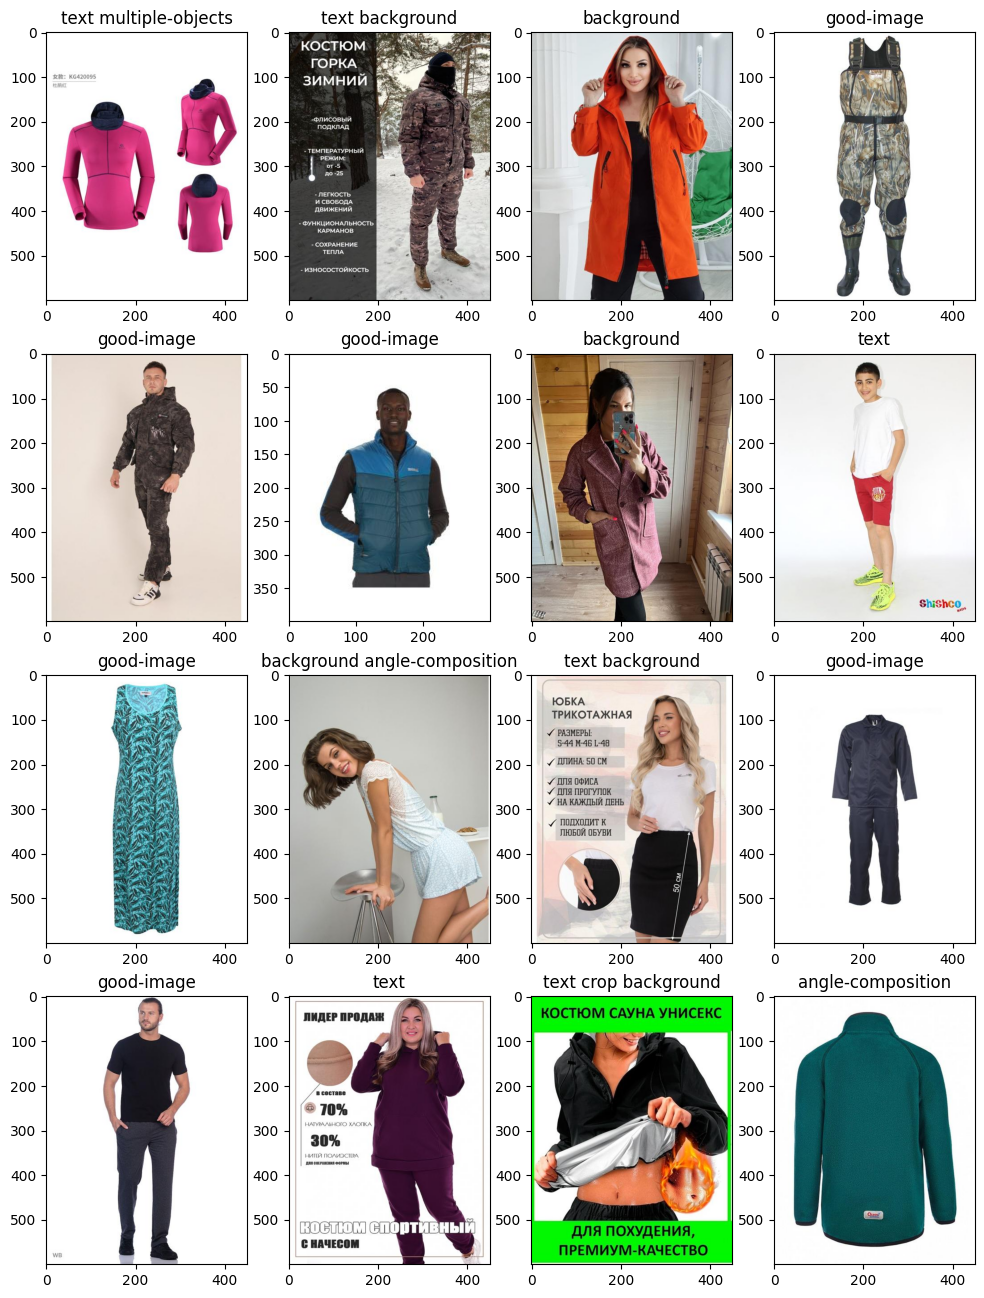

In [184]:
plot_img_grid(4,4,train_df)

In [283]:
class ImageDataset(torch.utils.data.Dataset):
        
    def __init__(self, df, transforms = None):
        self.df = df
        self.transforms = transforms
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.df.iloc[idx,0])
        label = self.df.iloc[idx, 2:].astype(np.int8)
        if self.transforms:
            return self.transforms(torch.Tensor(img).permute([2,1,0])), torch.Tensor([label])
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = img / 255.
        img = cv2.resize(img,(384, 384))
        return torch.Tensor(img).permute([2,1,0]), torch.Tensor(label.values)

In [284]:
train_set , dev_set = train_test_split(train_df,test_size = 0.3,random_state = CFG.SEED)
print(train_set.shape)

val_set, test_set = train_test_split(dev_set,test_size = 0.3,random_state = CFG.SEED)
print(val_set.shape, test_set.shape)

train_dataset = ImageDataset(train_set)
val_dataset = ImageDataset(val_set)
test_dataset = ImageDataset(test_set)

train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size = CFG.BATCH_SIZE,
                                               shuffle = True,
                                               num_workers=100)
val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                               batch_size = CFG.BATCH_SIZE,
                                               shuffle = False,
                                               num_workers=100)
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size = 1,
                                               shuffle = False,
                                               num_workers=100)

(3500, 9)
(1050, 9) (450, 9)


In [198]:
timm.list_models("resnet*")

['resnet10t',
 'resnet14t',
 'resnet18',
 'resnet18d',
 'resnet26',
 'resnet26d',
 'resnet26t',
 'resnet32ts',
 'resnet33ts',
 'resnet34',
 'resnet34d',
 'resnet50',
 'resnet50_clip',
 'resnet50_clip_gap',
 'resnet50_gn',
 'resnet50_mlp',
 'resnet50c',
 'resnet50d',
 'resnet50s',
 'resnet50t',
 'resnet50x4_clip',
 'resnet50x4_clip_gap',
 'resnet50x16_clip',
 'resnet50x16_clip_gap',
 'resnet50x64_clip',
 'resnet50x64_clip_gap',
 'resnet51q',
 'resnet61q',
 'resnet101',
 'resnet101_clip',
 'resnet101_clip_gap',
 'resnet101c',
 'resnet101d',
 'resnet101s',
 'resnet152',
 'resnet152c',
 'resnet152d',
 'resnet152s',
 'resnet200',
 'resnet200d',
 'resnetaa34d',
 'resnetaa50',
 'resnetaa50d',
 'resnetaa101d',
 'resnetblur18',
 'resnetblur50',
 'resnetblur50d',
 'resnetblur101d',
 'resnetrs50',
 'resnetrs101',
 'resnetrs152',
 'resnetrs200',
 'resnetrs270',
 'resnetrs350',
 'resnetrs420',
 'resnetv2_50',
 'resnetv2_50d',
 'resnetv2_50d_evos',
 'resnetv2_50d_frn',
 'resnetv2_50d_gn',
 'resnetv2

In [285]:
backbone = timm.create_model("resnetv2_50",pretrained=True,num_classes = 0)
backbone

ResNetV2(
  (stem): Sequential(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (stages): Sequential(
    (0): ResNetStage(
      (blocks): Sequential(
        (0): PreActBottleneck(
          (downsample): DownsampleConv(
            (conv): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm): Identity()
          )
          (norm1): BatchNormAct2d(
            64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): ReLU(inplace=True)
          )
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNormAct2d(
            64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): ReLU(inplace=True)
          )
          (conv2): Conv2d(64, 64, kernel_size=

In [303]:
class MLCNNet(nn.Module):
    
    def __init__(self,backbone,n_classes):
        super(MLCNNet,self).__init__();
        self.model = backbone
        self.classifier = nn.Sequential(nn.Linear(2048,256),
                                        nn.ReLU(),
                                        nn.Linear(256,n_classes))
    def forward(self,x):
        x = self.model(x)
        x = self.classifier(x)
        return x
    
Model = MLCNNet(backbone, 7)

class LitMLCNet(pl.LightningModule):
    
    def __init__(self,model):
        super().__init__();
        self.model = model
    
    def training_step(self,batch,batch_idx):
        x,y = batch
        outputs = self.model(x)
        loss = F.binary_cross_entropy_with_logits(outputs,y)
        self.log("train/loss", loss.item() / len(y), prog_bar=True, on_epoch=True)
        return loss
    
    def validation_step(self,batch,batch_idx):
        x,y = batch
        outputs = self.model(x)
        loss = F.binary_cross_entropy_with_logits(outputs,y)
        self.log("val/loss",loss.item() / len(y), prog_bar=True, on_epoch=True)
    
    def predict_step(self,batch,batch_idx,dataloader_idx=0):
        x,y = batch
        preds  = self.model(x)
        return preds,y
    
    def configure_optimizers(self):
        optim = torch.optim.AdamW(self.parameters(),lr = 8e-5)
        return optim
    
pl_Model = LitMLCNet(Model)



trainer = pl.Trainer(
    # default_root_dir = './',
                     
                    #  max_epochs = 2,
                    #  log_every_n_steps = 5,
                     accelerator='cuda',
                     devices=1,
                     callbacks=[EarlyStopping(monitor="val/loss", mode="min",patience=5)]
                    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [304]:
trainer.fit(pl_Model,
            train_dataloader,
            val_dataloader)

/home/prog3/.cache/pypoetry/virtualenvs/intership-opmGnuy9-py3.10/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type    | Params
----------------------------------
0 | model | MLCNNet | 24.0 M
----------------------------------
24.0 M    Trainable params
0         Non-trainable params
24.0 M    Total params
96.107    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

# Метрики

In [305]:
# Put your code here
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs

In [306]:
preds_labels = trainer.predict(pl_Model,test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [307]:
preds,labels =[],[]
for item in preds_labels:
    preds.append(torch.round(torch.sigmoid(item[0][0])).detach().numpy().tolist())
    labels.append(item[1][0].detach().numpy().tolist())

In [308]:
print(f"test_accuracy  - {accuracy_score(preds,labels)}")

test_accuracy  - 0.8377777777777777


## Baseline

In [ ]:
# Put your code here

## Решение

In [ ]:
# Put your code here

## Оценка результата

In [ ]:
# Put your code here

## Вывод

...

# Тестовый блок для проверки

Поместите сюда весь необходимый код для тестирования вашей модели на новых данных. Убедитесь что

- Импортируются все библиотеки и классы
- Подгружабтся веса с внешних ресурсов
- Происходит рассчет метрик
...

In [ ]:
# Put your code here